# **PLANO DE SAÚDE: FLORESTA ALEATÓRIA**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler         # Balanceamento de classes
from sklearn import ensemble                                   # Floresta aleatória
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

### Visualização da base de dados

In [ ]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
X = pd.get_dummies(X, drop_first = True)

### Balanceamento de base de dados grande (undersampling)

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento
y.value_counts()

,count
STATUS,
Mantem,67000
Up,13000
Down,10000
CancInvol,6000
CancVol,4000


In [ ]:
# Balanceamento
rus = RandomUnderSampler(random_state = 123)
X_sample, y_sample = rus.fit_resample(X, y)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento
y_sample.value_counts()

,count
STATUS,
CancInvol,4000
CancVol,4000
Down,4000
Mantem,4000
Up,4000


### Modelo 1: floresta aleatória com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(100, 1001),
    'max_depth': np.arange(2, 11)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC-OVR e k = 5 (EXECUÇÃO ONEROSA)
floresta = ensemble.RandomForestClassifier(class_weight = "balanced", random_state = 123)
cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(floresta, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=123),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_impurity_decrease': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'min_samples_leaf...
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 190, 'min_samples_leaf': 302, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'criterion': 'entropy'}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
30,"{'n_estimators': 190, 'min_samples_leaf': 302,...",0.873115,0.003811,1,0.598580,0.009671,2
44,"{'n_estimators': 140, 'min_samples_leaf': 316,...",0.872684,0.003761,2,0.598760,0.010845,1
53,"{'n_estimators': 200, 'min_samples_leaf': 472,...",0.871995,0.003361,3,0.597396,0.009133,3
50,"{'n_estimators': 140, 'min_samples_leaf': 672,...",0.857251,0.004606,4,0.578092,0.008354,5
62,"{'n_estimators': 180, 'min_samples_leaf': 720,...",0.856406,0.003724,5,0.575932,0.009309,6
...,...,...,...,...,...,...,...
20,"{'n_estimators': 90, 'min_samples_leaf': 756, ...",0.500000,0.000000,83,0.200000,0.000000,83
19,"{'n_estimators': 70, 'min_samples_leaf': 486, ...",0.500000,0.000000,83,0.200000,0.000000,83
7,"{'n_estimators': 140, 'min_samples_leaf': 470,...",0.500000,0.000000,83,0.200000,0.000000,83
85,"{'n_estimators': 200, 'min_samples_leaf': 719,...",0.500000,0.000000,83,0.200000,0.000000,83


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
floresta_1 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(100, 1001),
    'max_depth': np.arange(2, 11)
}

In [ ]:
# Validação cruzada estratificada aninhada com random search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
floresta = ensemble.RandomForestClassifier(class_weight = "balanced", random_state = 123)
inner_cv = KFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(floresta, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.872 0.867 0.878 0.872 0.876]
Média de AUC-OVR: 0.873
D.P. de AUC-OVR: 0.004


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.59  0.592 0.601 0.594 0.616]
Média de Acurácia Balanceada: 0.599
D.P. de Acurácia Balanceada: 0.01


### Aplicação do modelo final de floresta aleatória na base de dados



In [ ]:
# Atribuição das probabilidades preditas por categoria
floresta_1.fit(X, y)
y_prob = pd.DataFrame(floresta_1.predict_proba(X)[:,:], columns = floresta_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados_plano['y_pred'] = floresta_1.predict(X)

In [ ]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,4475,854,336,167,168
CancVol,671,2786,318,183,42
Down,1000,1983,5157,1555,305
Mantem,5884,5579,10723,25693,19121
Up,501,209,287,1893,10110


In [ ]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,0.75,0.14,0.06,0.03,0.03
CancVol,0.17,0.70,0.08,0.05,0.01
Down,0.10,0.20,0.52,0.16,0.03
Mantem,0.09,0.08,0.16,0.38,0.29
Up,0.04,0.02,0.02,0.15,0.78


### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = floresta_1.feature_importances_
features = X.columns

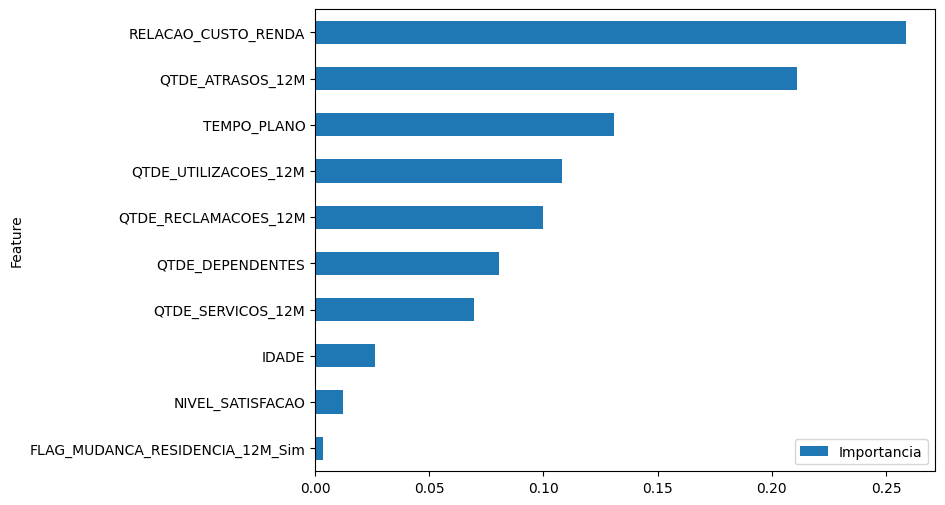

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(floresta_1)
valores_shap = explainer(X)

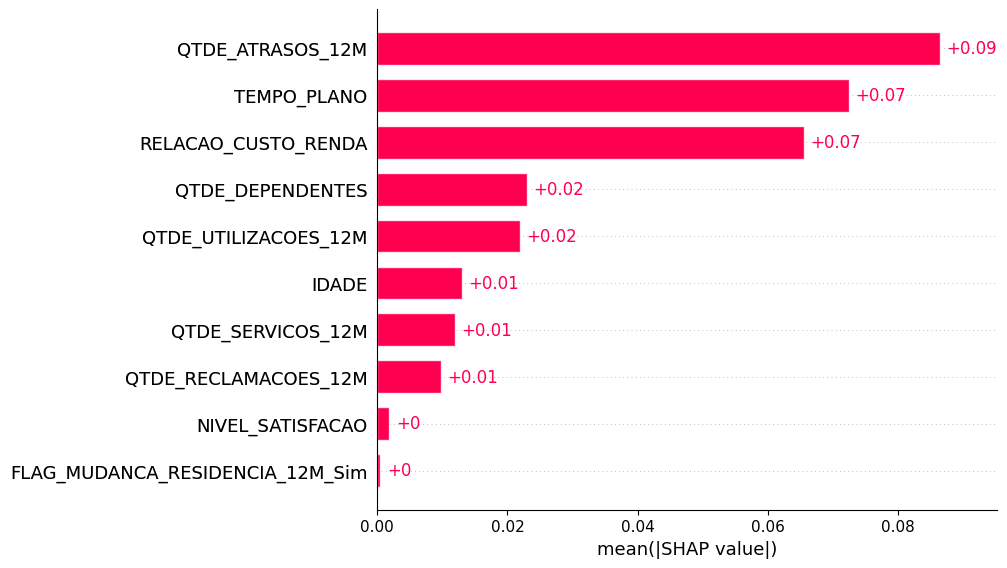

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancInvol'
shap.plots.bar(valores_shap[:,:,0])

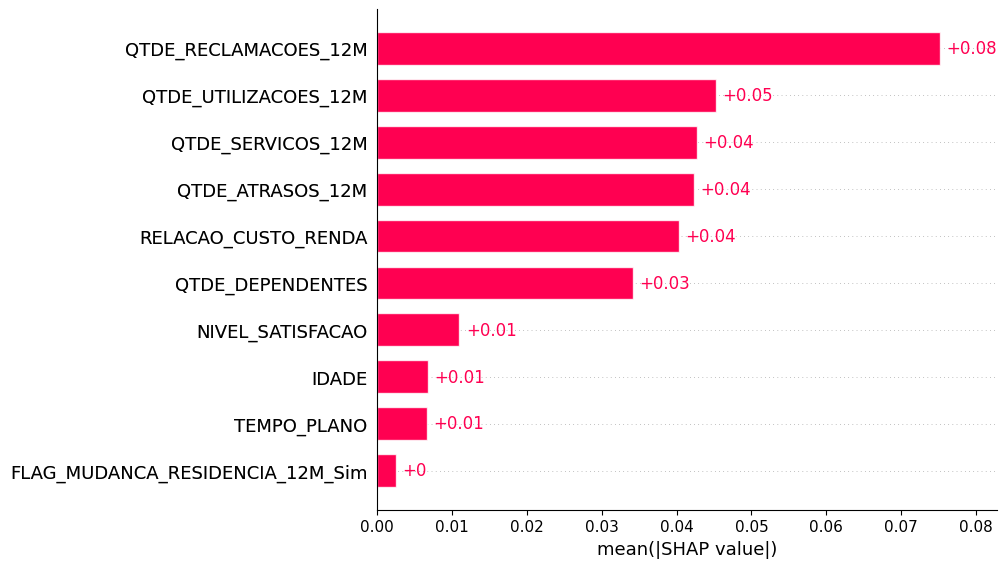

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancVol'
shap.plots.bar(valores_shap[:,:,1])

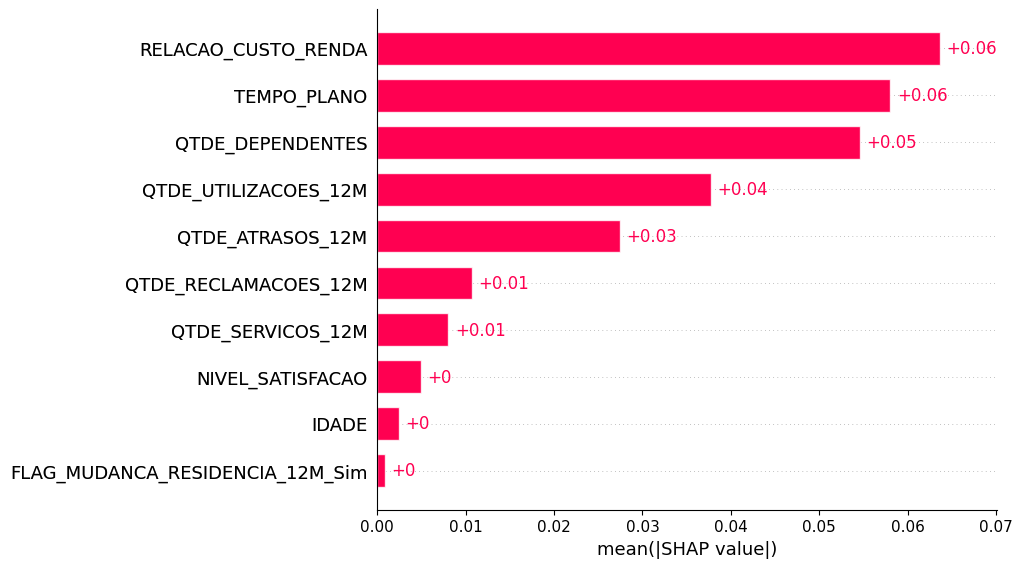

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Down'
shap.plots.bar(valores_shap[:,:,2])

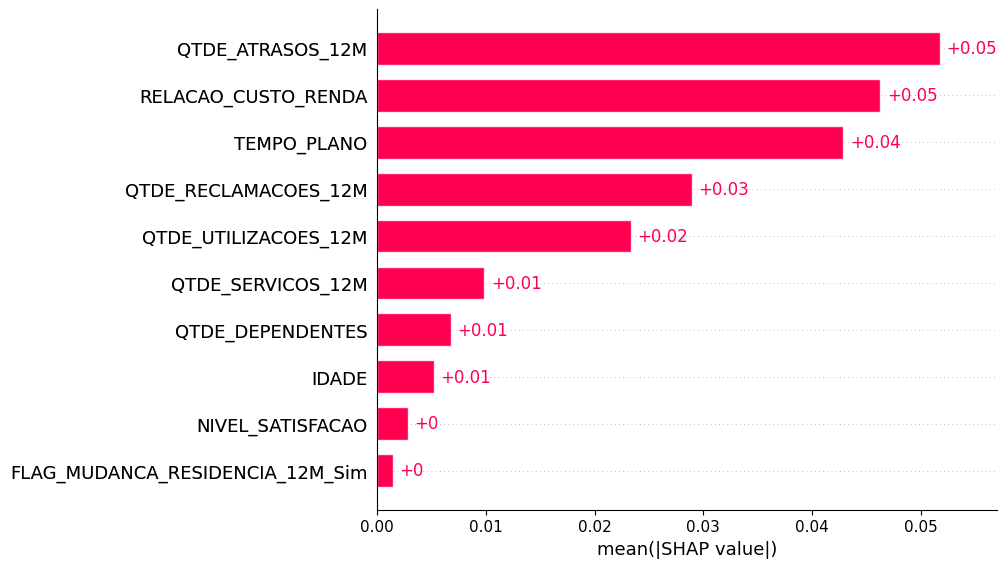

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Mantem'
shap.plots.bar(valores_shap[:,:,3])

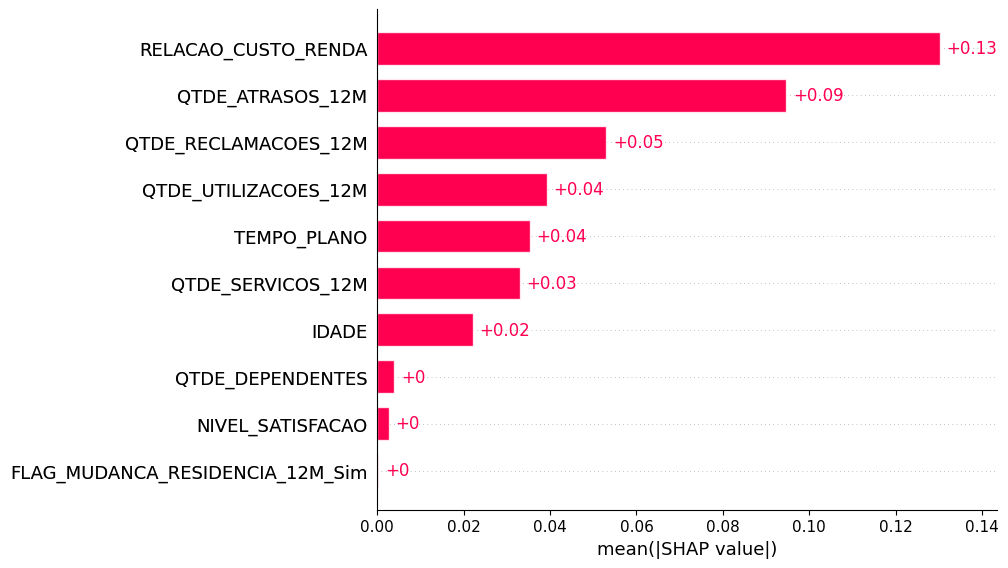

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Up'
shap.plots.bar(valores_shap[:,:,4])

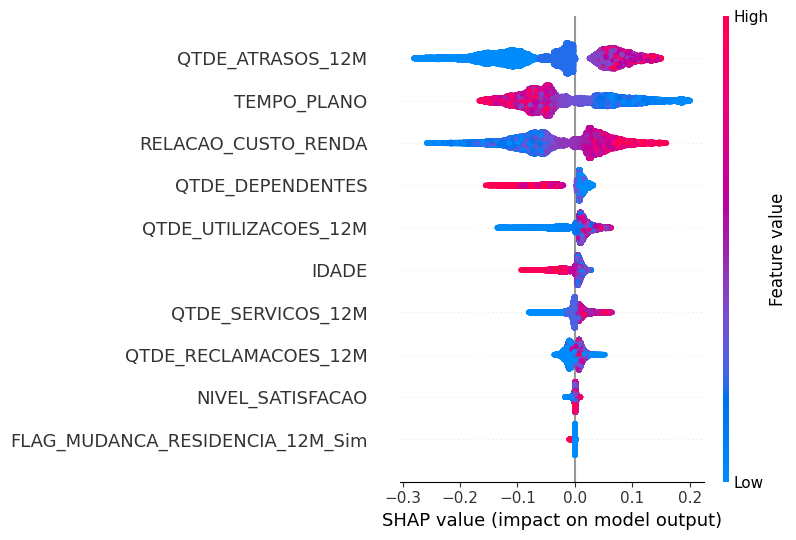

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancInvol'
shap.summary_plot(valores_shap[:,:,0])

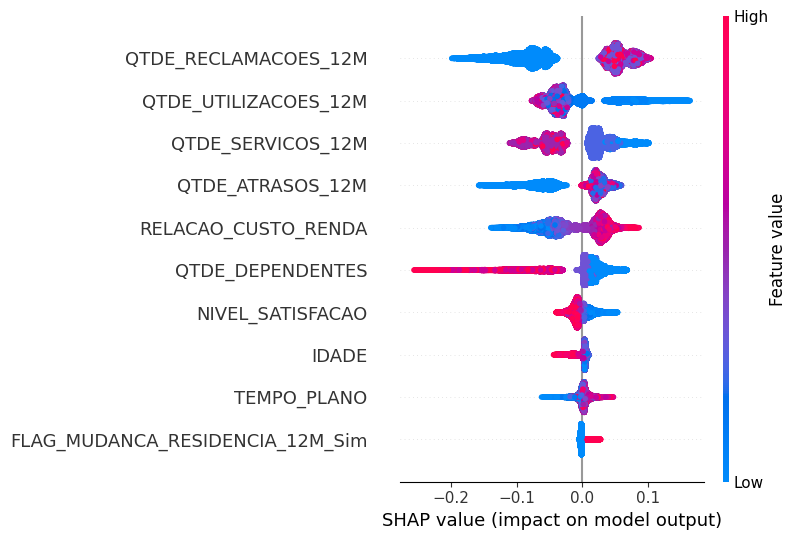

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancVol'
shap.summary_plot(valores_shap[:,:,1])

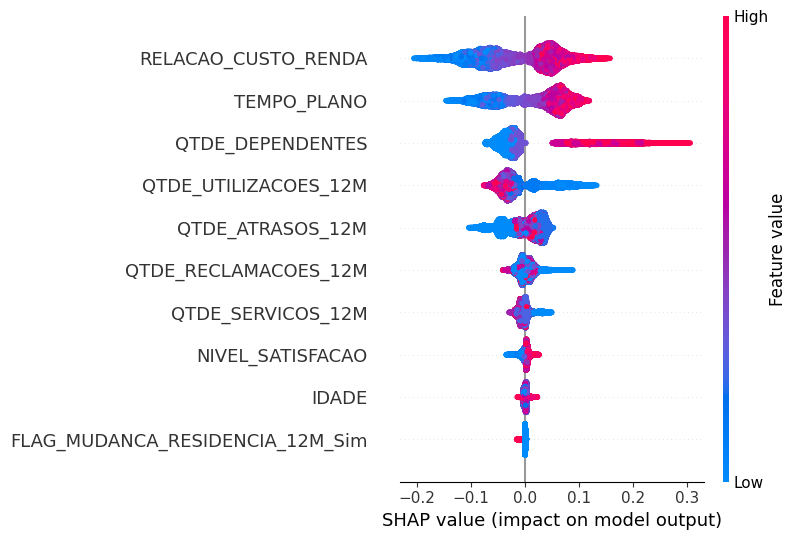

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Down'
shap.summary_plot(valores_shap[:,:,2])

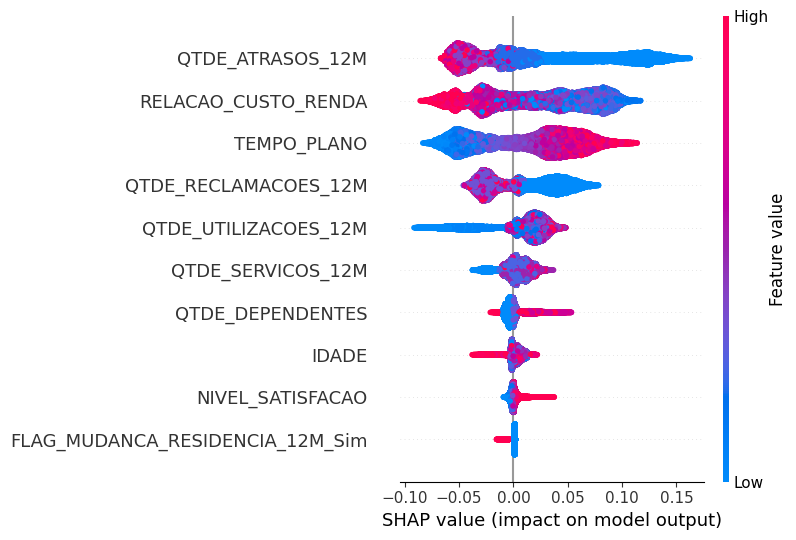

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Mantem'
shap.summary_plot(valores_shap[:,:,3])

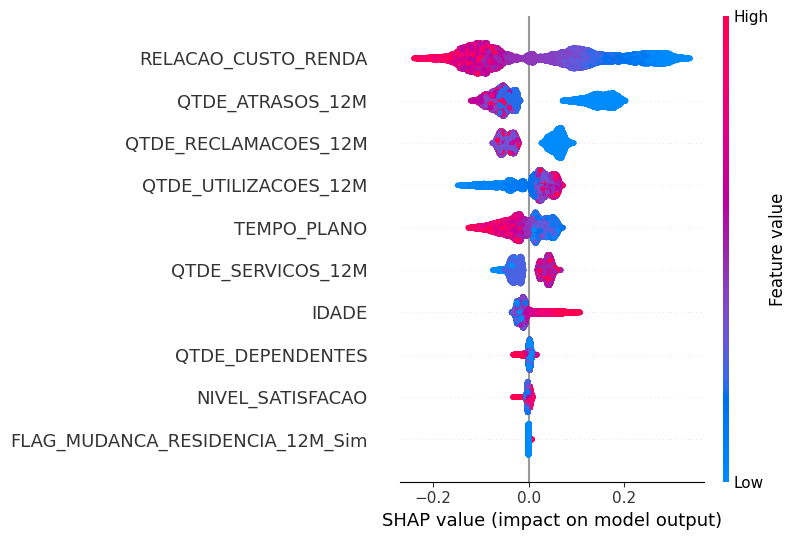

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Up'
shap.summary_plot(valores_shap[:,:,4])